# Presentation

On a previous Notebook, we tried to simulate a double pendulum. The dataset has been created with fixed parameters (masses and length of both arms). Now, we will try to improve the model by also considering those parameter. To do so, we will create the dataset, then we will compare 2 models with a different topology to send to the model those parameters. To finish, we will fine-tune the best model by playing on topology in order to have a good model. 

### Imports and functions

In [1]:
import numpy as np

import scipy.integrate as integrate

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.lines as mlines

from IPython.display import HTML

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, CuDNNLSTM, Concatenate, Input
from keras.callbacks import Callback

from sklearn.model_selection import train_test_split

import time
import pickle

Using TensorFlow backend.


In [2]:
G = 9.8  # acceleration due to gravity, in m/s^2

dt = 0.05  # simulation time in s
timestep = 100

th1_max = np.radians(180)  # max angle of the first arm in radians
w1_max = np.radians(180)   # max initial angular speed of the first arm in radians
th2_max = np.radians(180)  # max angle of the second arm in radians
w2_max = np.radians(180)   # max initial angular speed of the second arm in radians


t = np.arange(dt, (timestep+1)*dt, dt)  # create a time array  of n * dt steps

In [3]:
def derivs(state, t):

    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    del_ = state[2] - state[0]
    den1 = (M1 + M2)*L1 - M2*L1*np.cos(del_)*np.cos(del_)
    dydx[1] = (M2*L1*state[1]*state[1]*np.sin(del_)*np.cos(del_) +
               M2*G*np.sin(state[2])*np.cos(del_) +
               M2*L2*state[3]*state[3]*np.sin(del_) -
               (M1 + M2)*G*np.sin(state[0]))/den1

    dydx[2] = state[3]

    den2 = (L2/L1)*den1
    dydx[3] = (-M2*L2*state[3]*state[3]*np.sin(del_)*np.cos(del_) +
               (M1 + M2)*G*np.sin(state[0])*np.cos(del_) -
               (M1 + M2)*L1*state[1]*state[1]*np.sin(del_) -
               (M1 + M2)*G*np.sin(state[2]))/den2

    return dydx


def init():
    line.set_data([], [])
    line2.set_data([], [])
    time_text.set_text('')
    return line, line2, time_text


def animate(i):
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]
    
    thisx2 = [0, x3[i], x4[i]]
    thisy2 = [0, y3[i], y4[i]]

    line.set_data(thisx, thisy)
    line2.set_data(thisx2, thisy2)
    time_text.set_text(time_template % (i*dt))
    return line, time_text

def generate_state():
    return np.random.uniform(-1, 1, 4) * np.array([th1_max, w1_max, th2_max, w2_max])

def simulate(state):
    y = integrate.odeint(derivs, state, t)
    return y

def preprocess_result(X):
    h, w = X.shape
    new_X = np.zeros(shape=(h, w+2))
    new_X[:, 0] = np.cos(X[:, 0])
    new_X[:, 1] = np.sin(X[:, 0])
    new_X[:, 2] = X[:, 1]/w1_max
    new_X[:, 3] = np.cos(X[:, 2])
    new_X[:, 4] = np.sin(X[:, 2])
    new_X[:, 5] = X[:, 3]/w2_max
    return new_X

def preprocess_result_3D(X):
    h, w, i = X.shape
    new_X = np.zeros(shape=(h, w, i+2))
    new_X[:, :, 0] = np.cos(X[:, :, 0])
    new_X[:, :, 1] = np.sin(X[:, :, 0])
    new_X[:, :, 2] = X[:, :, 1]/w1_max
    new_X[:, :, 3] = np.cos(X[:, :, 2])
    new_X[:, :, 4] = np.sin(X[:, :, 2])
    new_X[:, :, 5] = X[:, :, 3]/w2_max
    return new_X

def get_batch(states, params, batch_size = 128):
    h, w, i = states.shape
    while True:
        for n in range(h//batch_size):
            start = n * batch_size
            stop = start + batch_size
            state = states[start:stop]
            param = params[start:stop]
            state = preprocess_result_3D(state)
            X = state[:, :-1, :]
            Y = state[:, 1:, :]
            P = np.repeat(param, timestep, axis=0).reshape(batch_size, timestep, 4)
            yield [[X, P], [Y]]
            
class LossHistory(Callback):
    def __init__(self, filename="result"):
        self.filename = filename
    
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.times = []
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.times.append(time.time()-self.start_time)
        
    def on_train_end(self, logs={}):
        result = {
            "losses" : self.losses,
            "val_losses" : self.val_losses,
            "times" : self.times
        }
        with open(self.filename, 'wb') as file:
            pickle.dump(result, file)

# Simulation

In order to see the chaotic behavior of the pendulum, let's simulate 2 pendulums with the same an initial state but differents parameters.

In [16]:
plt.close('all')

param1 = np.random.uniform(0.1, 1, 4)
L1, L2, M1, M2 = param1.tolist()

state = generate_state()                          # return an initial state

simulation1 = simulate(state)                     # return an array of the next timestep + 1 values
simulation1 = preprocess_result(simulation1)      # pre-processing as previously explained (not really required here)

# rendering 1
x1 = L1*simulation1[:, 1]
y1 = -L1*simulation1[:, 0]

x2 = L2*simulation1[:, 4] + x1
y2 = -L2*simulation1[:, 3] + y1

# rendering 2
param2 = np.random.uniform(0.1, 1, 4) # param1 * np.array([1.05, 1.05, 1.05, 1.05])
L1, L2, M1, M2 = param2.tolist()

simulation2 = simulate(state)
simulation2 = preprocess_result(simulation2)

x3 = L1*simulation2[:, 1]
y3 = -L1*simulation2[:, 0]

x4 = L2*simulation2[:, 4] + x3
y4 = -L2*simulation2[:, 3] + y3


# creation of the animation
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
line2, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

anim = animation.FuncAnimation(fig, animate, np.arange(1, timestep),
                              interval=1000*dt, blit=True, init_func=init)

# anim.save('double_pendulum.mp4', fps=15)
HTML(anim.to_html5_video())

# Create Dataset

Now, we have a way to simulate the model on <code>T</code> timesteps. To create the dataset, we will produce <code>N</code> simulations. To save memory, we will only save the T+1 timesteps for each simulation and a second matrix with only the parameter. Inputs will be pre-processed thru a generator during the training.

In [5]:
# sample_size = 100000

# X = np.zeros(shape=(sample_size, timestep+1, 4))
# P = np.zeros(shape=(sample_size, 4))

# for i in range(sample_size):
#     if i % 1000 == 0:
#         print("Generating simulation" ,i)
#     param = np.random.uniform(0.1, 1, 4)  
#     L1, L2, M1, M2 = param.tolist()
#     init_state = generate_state()
#     y = simulate(init_state)
#     X[i] = y
#     P[i] = param
    
# np.save("states.npy", X)
# np.save("params.npy", P)

# Create Models

We have 2 ways to send the pendulum parameters. We can send it to the fully-connected layer (red solution) or directly to the LSTM (green solution). 

<img src="Double_pendulum.png"/>

With the first option, we may think that this won't work well as the output is not evolving linearly with thoses parameters. If we send it to LSTM, this will be used to "solve" to ODE. This solution should perform better.

During this pahse, we will try both models, save their loss and val_loss per Epochs and see how they evolves. 

In [6]:
states = np.load("states.npy")
params = np.load("params.npy")

states_train, states_test, params_train, params_test = train_test_split(states, params, test_size=0.2, random_state=42)

train_generator = get_batch(states_train, params_train)
test_generator = get_batch(states_test, params_test)

### Model 1 (red solution)

In [8]:
inputs = Input((timestep, 6))
inputs2 = Input((timestep, 4))

l1 = CuDNNLSTM(32, return_sequences=True) (inputs)
l2 = CuDNNLSTM(32, return_sequences=True) (l1)
l3 = CuDNNLSTM(32, return_sequences=True) (l2)

c1 = Concatenate()([l3, inputs2])
d1 = Dense(6) (c1)

model = Model(inputs=[inputs, inputs2], outputs=[d1])

model.summary()

model.compile(loss='mean_squared_error', optimizer='Nadam') 

history = LossHistory("model1")

model.fit_generator(generator = train_generator, 
                    steps_per_epoch = len(states_train)//128, 
                    epochs = 100,
                    validation_data = test_generator,
                    validation_steps = len(states_test)//128,
                    verbose = 2,
                    callbacks = [history]
                   )

model.save("model.h5")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 6)       0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        (None, 100, 32)      5120        input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)        (None, 100, 32)      8448        cu_dnnlstm_1[0][0]               
__________________________________________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)        (None, 100, 32)      8448        cu_dnnlstm_2[0][0]               
__________________________________________________________________________________________________
input_2 (I

### Model 2 (green solution)

In [23]:
inputs = Input((timestep, 6))
inputs2 = Input((timestep, 4))

c1 = Concatenate()([inputs, inputs2])

l1 = CuDNNLSTM(32, return_sequences=True) (c1)
l2 = CuDNNLSTM(32, return_sequences=True) (l1)
l3 = CuDNNLSTM(32, return_sequences=True) (l2)

d1 = Dense(6) (l3)

model = Model(inputs=[inputs, inputs2], outputs=[d1])

model.summary()

model.compile(loss='mean_squared_error', optimizer='Nadam') 

history = LossHistory("model2")

model.fit_generator(generator = train_generator, 
                    steps_per_epoch = len(states_train)//128, 
                    epochs = 100,
                    validation_data = test_generator,
                    validation_steps = len(states_test)//128,
                    verbose = 2,
                    callbacks = [history]
                   )

model.save("model2.h5")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 100, 6)       0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 100, 4)       0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 100, 10)      0           input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
cu_dnnlstm_13 (CuDNNLSTM)       (None, 100, 32)      5632        concatenate_5[0][0]              
__________

### Results

With the Callback, we saved 2 dictionnary with the list of Loss. We can now check how it performed.

In [31]:
with open('model1', 'rb') as f:
    result1 = pickle.load(f)
    
with open('model2', 'rb') as f:
    result2 = pickle.load(f)

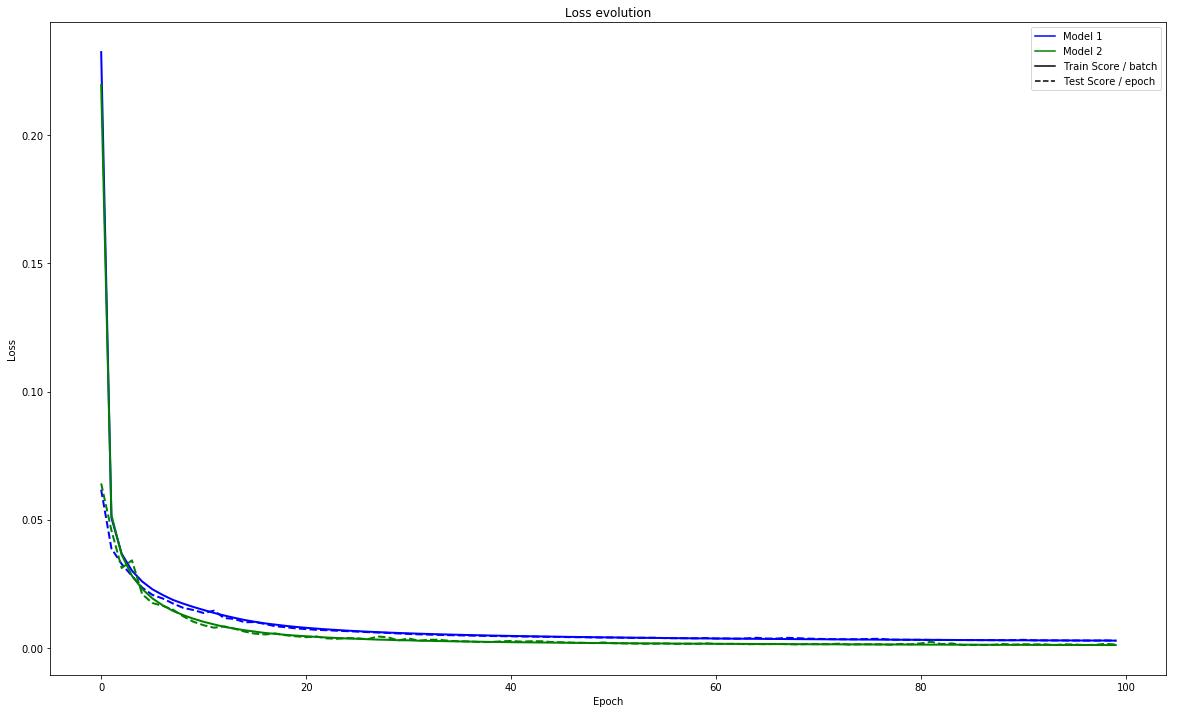

In [43]:
plt.figure(figsize=(20,12))
thk=2

y = result1["losses"]
y_val = result1["val_losses"]
plt.plot(y, "b", linewidth=thk)
plt.plot(y_val, "b", linewidth=thk, linestyle="--")

y = result2["losses"]
y_val = result2["val_losses"]
plt.plot(y, "g", linewidth=thk)
plt.plot(y_val, "g", linewidth=thk, linestyle="--")

blue_line = mlines.Line2D([], [], color='b', markersize=15, label='Model 1')
green_line = mlines.Line2D([], [], color='g', markersize=15, label='Model 2')
train_line = mlines.Line2D([], [], color='k', markersize=15, label='Train Score / batch')
test_line = mlines.Line2D([], [], color='k', markersize=15, linestyle="--", label='Test Score / epoch')

first_legend = plt.legend(handles=[blue_line, green_line, train_line, test_line], loc=1)
plt.title("Loss evolution")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Final Model

As we can see below, our guess was better. Sending parameters to the LSTM work better. Now as our input is a bit more complex, we may need to change the size of layers to learn faster. After some tries, I reached the current model. It is around 35% more accurate (val_loss of 7e-4 instead of 1.1e-3) and need around 50 Epochs to be trained instad of 100 for tests.

In [7]:
inputs = Input((timestep, 6))
inputs2 = Input((timestep, 4))

c1 = Concatenate()([inputs, inputs2])

l1 = CuDNNLSTM(48, return_sequences=True) (c1)
l2 = CuDNNLSTM(48, return_sequences=True) (l1)
l3 = CuDNNLSTM(32, return_sequences=True) (l2)

d1 = Dense(16) (l3)
d2 = Dense(6) (d1)

model = Model(inputs=[inputs, inputs2], outputs=[d2])

model.summary()

model.compile(loss='mean_squared_error', optimizer='Nadam') 

history = LossHistory("model_final")

model.fit_generator(generator = train_generator, 
                    steps_per_epoch = len(states_train)//128, 
                    epochs = 50,
                    validation_data = test_generator,
                    validation_steps = len(states_test)//128,
                    verbose = 2,
                    callbacks = [history]
                   )

model.save("model_final.h5")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 6)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100, 4)       0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 100, 10)      0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        (None, 100, 48)      11520       concatenate_1[0][0]              
__________

# Generator

As we did previously, we can compare the simulation with the prediction at fixed parameters and initial state.

In [4]:
inputs = Input(batch_shape = (1, 1, 6))
inputs2 = Input(batch_shape = (1, 1, 4))

c1 = Concatenate()([inputs, inputs2])

l1 = CuDNNLSTM(48, stateful=True, return_sequences=True) (c1)
l2 = CuDNNLSTM(48, stateful=True, return_sequences=True) (l1)
l3 = CuDNNLSTM(32, stateful=True, return_sequences=True) (l2)

d1 = Dense(16) (l3)
d2 = Dense(6) (d1)

newModel = Model(inputs=[inputs, inputs2], outputs=[d2])

try:
    weight = model.get_weights()
except:
    model = load_model('model_final.h5')
    weight = model.get_weights()
newModel.set_weights(weight)

newModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (1, 1, 6)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (1, 1, 4)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (1, 1, 10)           0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        (1, 1, 48)           11520       concatenate_1[0][0]              
__________

In [12]:
plt.close('all')

param = np.random.uniform(0.1, 1, 4)
L1, L2, M1, M2 = param.tolist()

newModel.reset_states()                # required to reset the cell state and hidden state

init_state = generate_state()          # new initial position
simulation = simulate(init_state)      # simulation with scipy
y = preprocess_result(simulation)      # pre-process the input with cos and sin

prediction = []
init_state = y[0, :]                   # reuse the preprocess_result of the initial state
state = np.expand_dims(init_state, 0)
state = np.expand_dims(state, 0)

param = np.expand_dims(param, 0)
# param = np.repeat(param, timestep, axis=0)
param = np.expand_dims(param, 0)

for i in range(timestep+1):            
    state = newModel.predict([state, param])
    prediction.append(state[0, 0, :])  # generation of T timesteps
    
prediction = np.array(prediction)

# now we calculate the extrapolated angle
theta1_est = np.arctan2(prediction[:, 1], prediction[:, 0])
theta2_est = np.arctan2(prediction[:, 4], prediction[:, 3])

# and we correct it by inferences
prediction[:, 0] = np.cos(theta1_est)
prediction[:, 1] = np.sin(theta1_est)
prediction[:, 3] = np.cos(theta2_est)
prediction[:, 4] = np.sin(theta2_est)

# rendering simulation
x1 = L1*y[:, 1]
y1 = -L1*y[:, 0]

x2 = L2*y[:, 4] + x1
y2 = -L2*y[:, 3] + y1

# rendering prediction
x3 = L1*prediction[:, 1]
y3 = -L1*prediction[:, 0]

x4 = L2*prediction[:, 4] + x3
y4 = -L2*prediction[:, 3] + y3

# Animation
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
line2, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(y1)),
                              interval=1000*dt, blit=True, init_func=init)

# ani.save('double_pendulum_1.mp4', fps=15)
HTML(ani.to_html5_video())

# Conclusion 

This model is more complex. In fact, in addition to having also to take into consideration the paramters of the model, rande of initial states have been increased to any angles. As a result, there is more dynamic solution which makes the prediciton more complexe. Neverthess, the outcome is quite realistic and accurate. 